# Autoencoders para la detección de anomalías cardiacas


## 1- El problema a resolver

Detectar la presencia (sujeto _anormal_) o ausencia (sujeto _normal_) de irregularidades en el ritmo cardiaco, a partir de señales electrocardiográficas (ECG):

![](https://drive.google.com/uc?export=view&id=1pzydaNRbcSh1E-S4Ebh0jJEqsim6DeM9)

El problema es que usualmente se cuenta con sets de datos **desbalanceados** con más datos normales que anormales.


## 2 El set de datos

Se usará el set [ECG5000](https://timeseriesclassification.com/description.php?Dataset=ECG5000) con 7600 datos de entrenamiento y 1900 de prueba.

Cada dato contiene un ciclo cardiaco con 140 muestras, y que puede pertenecer a una de 5 categorías:

1. Normal
2. Anormal: contracción ventricular prematura
3. Anormal: contracción supra-ventricular prematura
4. Anormal: latido ectópico
5. Anormal pero patología desconocida

![](https://drive.google.com/uc?export=view&id=1x_sUD1rbM4MM4--s9D4wacRIWEo8aAzL)


## 3- Autoencoders y detección de anomalías

El problema del set ECG5000 es que contiene 4427 datos normales y 3173 anormales, es decir está desbalanceado.

De hecho para ciertas categorías anormales (2 a 4) se tienen muy pocos datos:

| Categoría   | Nro. datos |
| ----------- | ---------- |
| 1 (normal)  | 4427       |
| 2 (anormal) | 2683       |
| 3 (anormal) | 149        |
| 4 (anormal) | 306        |
| 5 (anormal) | 35         |

Así que en lugar de un modelo de clasificación convencional (como una Red Neuronal) se usará un Autoencoder:

![](https://drive.google.com/uc?export=view&id=1LnoIDmfctQr5wmJaojFrZEA1ygPynylu)

El autoencoder se entrenará **únicamente con datos normales**. Así, al reconstruir un dato anormal **el error será alto**.


## 4- Implementación


### 4.1. Preparación de Google Drive y lectura de los sets de entrenamiento y prueba


In [ ]:
!pip install wandb

In [6]:
import wandb
wandb.init()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [7]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt

In [8]:
keras.__version__

'3.0.5'

In [9]:
# from google.colab import drive
# drive.mount('/gdrive')

In [16]:
ruta = "/gdrive/MyDrive/videos/2021-06-25/"
ruta = ""

df_train = pd.read_csv(ruta + "ECG5000_train.csv")
df_test = pd.read_csv(ruta + "ECG5000_test.csv")

In [17]:
df_train.shape, df_test.shape

((7600, 141), (1900, 141))

In [18]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,-1.30300,-0.83573,-1.9336,-2.09420,-2.02840,-1.2531,-0.52638,-0.089286,-0.07557,...,-1.45820,-1.6676,-1.5977,-1.67930,-1.677200,-1.69370,-1.79410,-1.35940,-2.08120,-2.82880
1,2,0.32288,-0.87847,-1.8023,-2.66850,-3.26550,-3.3326,-2.88000,-2.227400,-1.54360,...,-1.23050,-1.7218,-2.1953,-2.74890,-3.446500,-3.66210,-3.01820,-1.65140,-0.23670,0.82832
2,2,1.39340,1.59260,1.2420,0.79449,0.19577,-0.3156,-0.58053,-0.945020,-1.23350,...,-1.90850,-2.5295,-3.0614,-3.50370,-3.900400,-4.24600,-4.13380,-3.19850,-2.42200,-1.07370
3,1,-3.52270,-5.02610,-4.3613,-4.10570,-3.10420,-1.8178,-1.39840,-1.070100,-0.40691,...,0.83038,1.0084,1.1830,0.94636,0.952130,0.79343,0.84741,1.01390,0.31234,-2.19060
4,1,-1.91820,-3.22510,-3.4652,-4.00800,-3.87030,-3.3581,-2.28540,-1.728500,-1.42220,...,1.77690,1.5029,1.1651,0.46073,0.019172,-0.32739,-0.48051,-0.18814,0.14284,-0.66844


In [19]:
df_train["0"].value_counts()

y_train = df_train["0"] - 1
x_train = df_train.drop(columns=["0"])
y_test = df_test["0"] - 1
x_test = df_test.drop(columns=["0"])

# Tu turno: como lo resolverías?


In [20]:
140 * 5 + 5

705

In [28]:
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback, WandbMetricsLogger


wandb.init(
    project="mlbio2024-ecg",
    
    config={
        "inputLayer":140,
        "layer_1":64,
        "activation_1":"leaky_relu",
        "n_classes":5,
        "activation_output":"softmax",
        "loss_function":"sparse_categorical_crossentropy",
        "optimizer":"sgd",
        "metrics":"accuracy",
        "epochs":30,
        "batch_size":64,
        
    }
)

config = wandb.config

callbacks_model = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=1),
    ModelCheckpoint(filepath="model.keras", save_best_only=True, verbose=1),
    WandbMetricsLogger()
    
]

model = Sequential()
model.add(Input(shape=(config.inputLayer,)))
model.add(Dense(config.layer_1, activation=config.activation_1))
model.add(Dense(config.n_classes, activation=config.activation_output))

model.compile(
    loss=config.loss_function, 
    optimizer=config.optimizer, 
    metrics=[config.metrics]
)

history = model.fit(
    x_train, 
    y_train, 
    epochs=config.epochs, 
    batch_size=config.batch_size, 
    validation_data=(x_test, y_test), 
    callbacks=callbacks_model
)

# model.summary()

predictions = model.predict(x_train)
predictions_label = np.argmax(predictions, axis=1)

predictions_label[:2]
accuracy = np.mean(predictions_label == y_train)
wandb.log({"accuracy_train": accuracy})

wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch 1/30
117/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8286 - loss: 0.5635
Epoch 1: val_loss improved from inf to 0.25193, saving model to model.keras


wandb: ERROR Unable to log learning rate.


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8303 - loss: 0.5588 - val_accuracy: 0.9311 - val_loss: 0.2519
Epoch 2/30
116/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9258 - loss: 0.2778
Epoch 2: val_loss improved from 0.25193 to 0.22509, saving model to model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9259 - loss: 0.2772 - val_accuracy: 0.9416 - val_loss: 0.2251
Epoch 3/30
113/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9335 - loss: 0.2371
Epoch 3: val_loss improved from 0.22509 to 0.21104, saving model to model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9335 - loss: 0.2372 - val_accuracy: 0.9426 - val_loss: 0.2110
Epoch 4/30
 90/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9377 - loss: 0.2279
Epoch 4: val_loss improved from 0.21104 to 0.20237, saving model to model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9376 - loss: 0.2279 - val_accuracy: 0.9453 - val_loss: 0.2024
Epoch 5/30
 85/119 ━━━━━━━━━━━━━━━

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy_train,▁
epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▄▅▅▅▆▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch/val_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy_train,0.95289
epoch/accuracy,0.95316
epoch/epoch,29
epoch/loss,0.15937
epoch/val_accuracy,0.95579


In [50]:
accuracy = np.mean(predictions_label == y_train)
print(accuracy)

0.9636842105263158


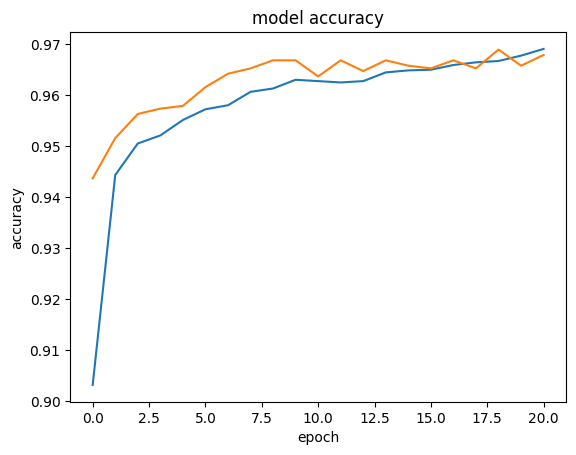

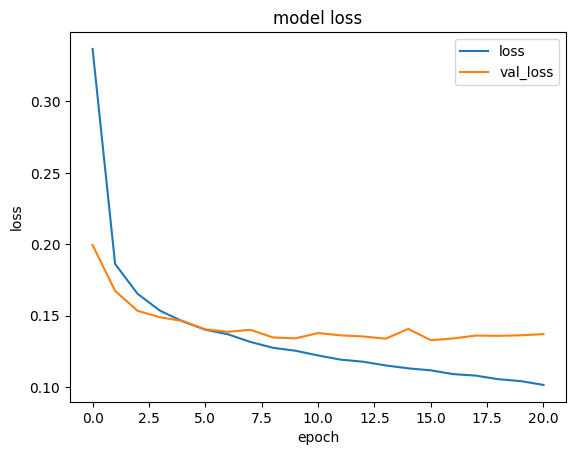

In [58]:
# plot history train, test epochs
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()
# plot loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(("loss", "val_loss"))

In [63]:
np.argmax(model.predict(x_test[:5]), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([1, 1, 1, 1, 0])

# Autoencoders


### 4.2. Sets de entrenamiento y validación


In [64]:
# Pandas a arreglos numpy
datos_train = df_train.values
datos_test = df_test.values

# Etiquetas
cat_train = datos_train[:, 0]
cat_test = datos_test[:, 0]

# Subdivisión por categorías
x_train_1 = datos_train[cat_train == 1, 1:]
x_train_2 = datos_train[cat_train == 2, 1:]
x_train_3 = datos_train[cat_train == 3, 1:]
x_train_4 = datos_train[cat_train == 4, 1:]
x_train_5 = datos_train[cat_train == 5, 1:]

x_test_1 = datos_test[cat_test == 1, 1:]
x_test_2 = datos_test[cat_test == 2, 1:]
x_test_3 = datos_test[cat_test == 3, 1:]
x_test_4 = datos_test[cat_test == 4, 1:]
x_test_5 = datos_test[cat_test == 5, 1:]

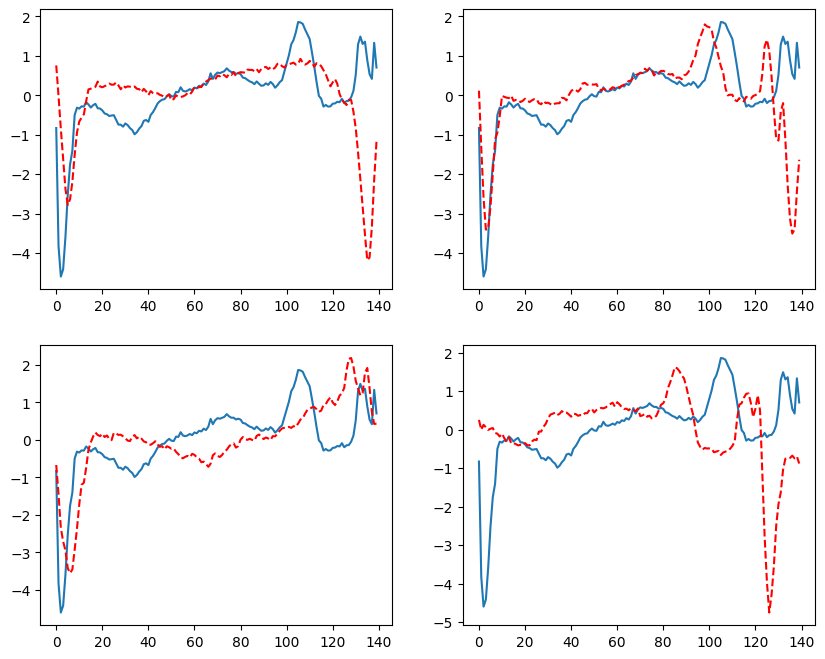

In [65]:
# Dibujar un dato normal y uno de cada anormal

ind = 22
normal = x_train_1[ind]
anormal_2 = x_train_2[ind]
anormal_3 = x_train_3[ind]
anormal_4 = x_train_4[ind]
anormal_5 = x_train_5[ind]

plt.figure(figsize=(10, 8))
# plt.grid()
plt.subplot(2, 2, 1)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_2, "r--")
plt.subplot(2, 2, 2)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_3, "r--")
plt.subplot(2, 2, 3)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_4, "r--")
plt.subplot(2, 2, 4)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_5, "r--")
plt.show()

### 4.3. Preprocesamiento (normalización)


In [67]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

min_max_scaler.fit(x_train_1)

# Entrenar el escalador con los datos de x_train_1
x_train_1_s = min_max_scaler.transform(x_train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(x_train_1), np.max(x_train_1)))
print('Mínimo y máximo normalización: {:.1f}, {:.1f}'.format(np.min(x_train_1_s), np.max(x_train_1_s)))

# Escalar los datos de x_test_1, x_test_2, x_test_3, x_test_4, x_test_5
x_test_1_s = min_max_scaler.transform(x_test_1)
x_test_2_s = min_max_scaler.transform(x_test_2)
x_test_3_s = min_max_scaler.transform(x_test_3)
x_test_4_s = min_max_scaler.transform(x_test_4)
x_test_5_s = min_max_scaler.transform(x_test_5)

Mínimo y máximo originales: -7.1, 5.0
Mínimo y máximo normalización: 0.0, 1.0


### 4.4. Creación del Autoencoder en TensorFlow/Keras


In [73]:
# Crear un autoencoder con tres capas de encoder y tres de decoder
# dimensiones: input(140) -> 32 -> 16 -> 8 -> 16 -> 32 -> Output(140)


autoencoder = Sequential()
autoencoder.add(Input(shape=(140,)))
autoencoder.add(Dense(32, activation="relu"))
autoencoder.add(Dense(16, activation="relu"))
autoencoder.add(Dense(8, activation="relu"))
autoencoder.add(Dense(16, activation="relu"))
autoencoder.add(Dense(32, activation="relu"))
autoencoder.add(Dense(140, activation="linear"))

autoencoder.summary()


autoencoder.compile(optimizer="adam", loss="mean_squared_error")


historia = autoencoder.fit(
    x_train_1_s, 
    x_train_1_s,
    validation_data=(x_test_1_s, x_test_1_s),
    epochs=200,
    batch_size=512
    )

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 32)             │         4,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 140)            │         4,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,484 (40.95 KB)

 Trainable params: 10,484 (40.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.2743 - val_loss: 0.2337
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2166 - val_loss: 0.1642
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1484 - val_loss: 0.1043
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0923 - val_loss: 0.0606
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0530 - val_loss: 0.0352
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0309 - val_loss: 0.0220
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198 - val_loss: 0.0155
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0141 - val_loss: 0.0125
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - val_loss: 0.0107
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - val_loss: 0.010

### 4.5. Optimización y entrenamiento

La pérdida será el error absoluto medio (_Mean Absolute Error_, MAE):

$MAE = \frac{\sum_{i=1}^{140} |x_i - \hat{x_i}|}{140}$


In [72]:
historia = autoencoder.fit(
    x_train_1_s, 
    x_train_1_s,
    validation_data=(x_test_1_s, x_test_1_s),
    epochs=100,
    batch_size=512
    )

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - val_loss: 0.0106
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - val_loss: 0.0

In [45]:
# Compilar el modelo el optimizador (adam) y la función de pérdida (mae)

# Entrenar el modelo: epochs=20, batch_size=512


Epoch 1/20


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1271 - val_loss: 0.1261
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1236 - val_loss: 0.1201
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1166 - val_loss: 0.1093
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1053 - val_loss: 0.0980
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0949 - val_loss: 0.0882
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0848 - val_loss: 0.0808
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0782 - val_loss: 0.0752
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0728 - val_loss: 0.0714
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0696 - val_loss: 0.0687
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0675 - val_loss: 0.0670
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0659 - val_loss: 0.0661
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0641 - val_loss: 0.0656
Epoch 13/20
9/9 ━━━━━━━

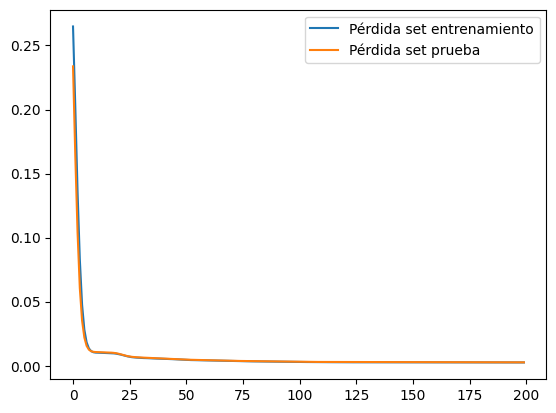

In [74]:
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.legend()

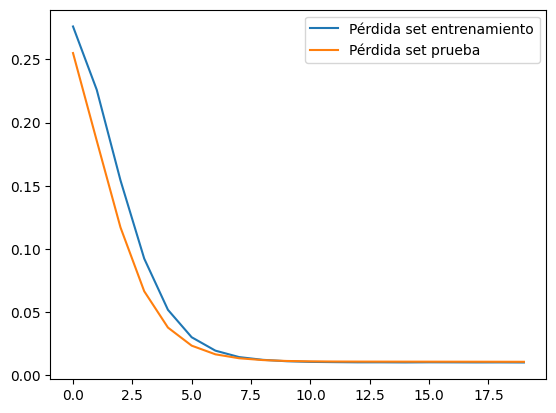

## 5- Clasificación


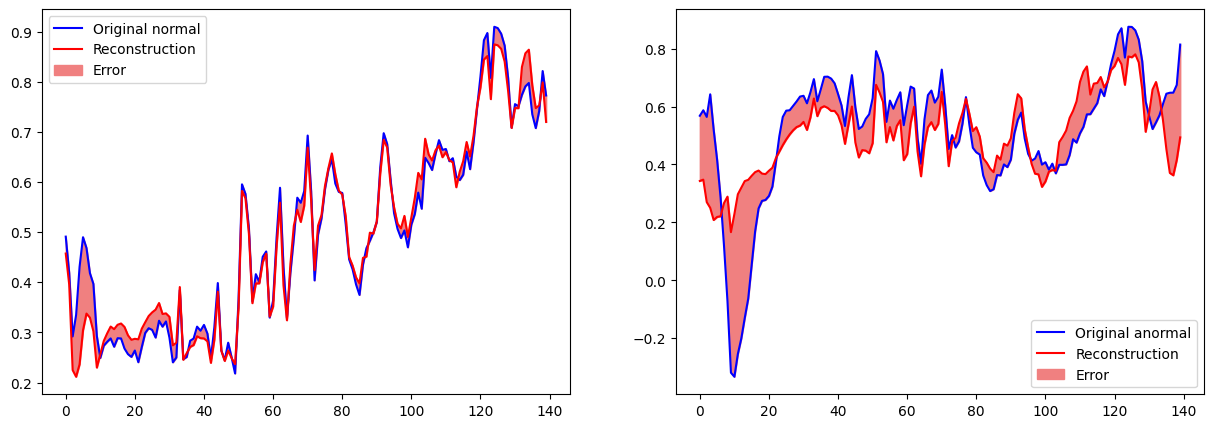

In [75]:
# ¿Qué tan bien reconstruye un dato "normal" y uno anormal?
rec_normal = autoencoder(x_test_1_s).numpy()
rec_anormal = autoencoder(x_test_5_s).numpy()

dato = 5

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(x_test_1_s[dato], "b")
plt.plot(rec_normal[dato], "r")
plt.fill_between(np.arange(140), rec_normal[dato], x_test_1_s[dato], color="lightcoral")
plt.legend(labels=["Original normal", "Reconstruction", "Error"])

plt.subplot(1, 2, 2)
plt.plot(x_test_5_s[dato], "b")
plt.plot(rec_anormal[dato], "r")
plt.fill_between(
    np.arange(140), rec_anormal[dato], x_test_5_s[dato], color="lightcoral"
)
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

In [76]:
# Normal

print(
    "mae de una muestra normal: ",
    keras.losses.mean_absolute_error(x_test_1_s[dato], rec_normal[dato]).numpy(),
)
print(
    "mae de una muestra anormal: ",
    keras.losses.mean_absolute_error(x_test_5_s[dato], rec_anormal[dato]).numpy(),
)

mae de una muestra normal:  0.026296344
mae de una muestra anormal:  0.118844


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


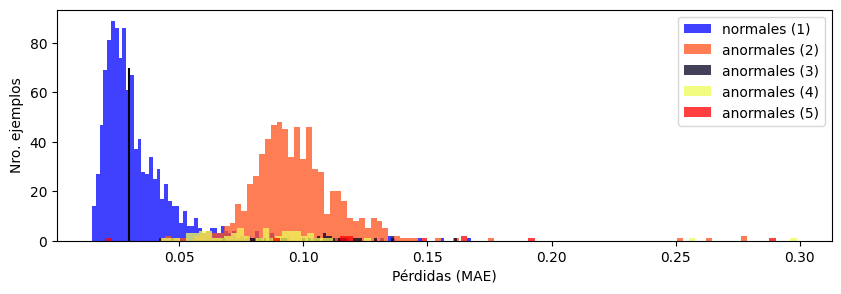

In [77]:
# Distribuciones de los errores de construcción
# para cada categoría


rec_1 = autoencoder.predict(x_test_1_s)
rec_2 = autoencoder.predict(x_test_2_s)
rec_3 = autoencoder.predict(x_test_3_s)
rec_4 = autoencoder.predict(x_test_4_s)
rec_5 = autoencoder.predict(x_test_5_s)

loss_1 = keras.losses.mean_absolute_error(rec_1, x_test_1_s)
loss_2 = keras.losses.mean_absolute_error(rec_2, x_test_2_s)
loss_3 = keras.losses.mean_absolute_error(rec_3, x_test_3_s)
loss_4 = keras.losses.mean_absolute_error(rec_4, x_test_4_s)
loss_5 = keras.losses.mean_absolute_error(rec_5, x_test_5_s)


plt.figure(figsize=(10, 3))
plt.hist(loss_1[None, :], bins=100, alpha=0.75, label="normales (1)", color="blue")
plt.hist(loss_2[None, :], bins=100, alpha=0.75, color="#ff521b", label="anormales (2)")
plt.hist(loss_3[None, :], bins=100, alpha=0.75, color="#020122", label="anormales (3)")
plt.hist(loss_4[None, :], bins=100, alpha=0.75, color="#eefc57", label="anormales (4)")
plt.hist(loss_5[None, :], bins=100, alpha=0.75, color="r", label="anormales (5)")
plt.xlabel("Pérdidas (MAE)")
plt.ylabel("Nro. ejemplos")
plt.legend(loc="upper right")
# plt.vlines(0.08,0,70,'k')
umbral = np.mean(loss_1) + np.std(loss_1)

# Linea vertical
plt.vlines(0.03, 0, 70, "k")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


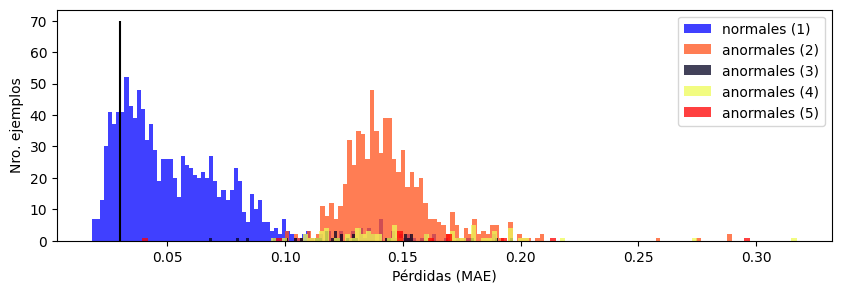

### 5.1. Sensitividad y especificidad

- Verdaderos positivos (TP): anormales que han sido correctamente clasificados como anormales
- Falsos negativos (FN): anormales que han sido clasificados erróneamente como normales
- Verdaderos negativos (TN): normales que han sido correctamente clasificados como normales
- Falsos positivos (FP): normales que han sido clasificados erróneamente como anormales

La **precisión** mide la proporción de pacientes detectados como enfermos que realmente están enfermos:

$precisión = \frac{TP}{TP+FP}$

La **sensitividad** mide la proporción de anormales que fueron detectados correctamente como anormales. Una sensitividad del 100% detectará a todos los pacientes enfermos:

$sensitividad (Recall) = \frac{TP}{TP+FN}$

La **especificidad** mide la proporción de normales que fueron detectados correctamente como normales. Una especificidad del 100% detectará a todos los pacientes sanos:

$especificidad (Negative Recall) = \frac{TN}{TN+FP}$


In [56]:
# Calcular predicciones individuales
def predecir(modelo, datos, umbral):
    reconstrucciones = modelo(datos)
    perdida = keras.losses.mean_absolute_error(reconstrucciones, datos).numpy()
    return perdida < umbral


def calcular_sensitividad(prediccion, titulo):
    TP = np.count_nonzero(~prediccion)
    FN = np.count_nonzero(prediccion)
    sen = 100 * (TP / (TP + FN))

    print(titulo + ": {:.1f}%".format(sen))


def calcular_especificidad(prediccion, titulo):
    TN = np.count_nonzero(prediccion)
    FP = np.count_nonzero(~prediccion)
    esp = 100 * (TN / (TN + FP))

    print(titulo + ": {:.1f}%".format(esp))
    return esp

 1/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Especificidad (cat. 1, normales): 85.4%
Sensitividad (Recall) (cat. 2, anormales): 100.0%
Sensitividad (Recall) (cat. 3, anormales): 97.0%
Sensitividad (Recall) (cat. 4, anormales): 100.0%
Sensitividad (Recall) (cat. 5, anormales): 97.0%


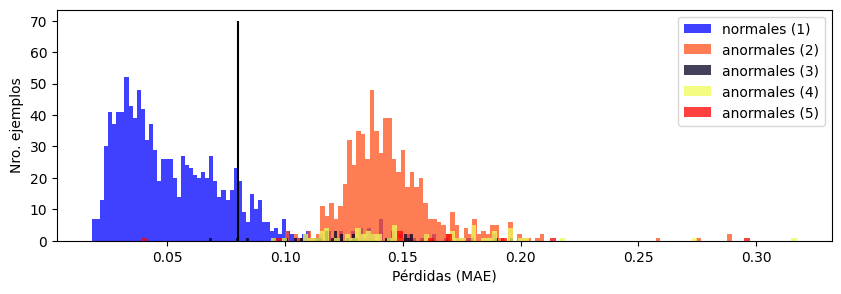

In [63]:
umbral = np.mean(loss_1) + np.std(loss_1)
umbral = 0.08


# Distribuciones de los errores de construcción
# para cada categoría

import tensorflow as tf

rec_1 = autoencoder.predict(x_test_1_s)
rec_2 = autoencoder.predict(x_test_2_s)
rec_3 = autoencoder.predict(x_test_3_s)
rec_4 = autoencoder.predict(x_test_4_s)
rec_5 = autoencoder.predict(x_test_5_s)

loss_1 = keras.losses.mean_absolute_error(rec_1, x_test_1_s)
loss_2 = keras.losses.mean_absolute_error(rec_2, x_test_2_s)
loss_3 = keras.losses.mean_absolute_error(rec_3, x_test_3_s)
loss_4 = keras.losses.mean_absolute_error(rec_4, x_test_4_s)
loss_5 = keras.losses.mean_absolute_error(rec_5, x_test_5_s)


plt.figure(figsize=(10, 3))
plt.hist(loss_1[None, :], bins=100, alpha=0.75, label="normales (1)", color="blue")
plt.hist(loss_2[None, :], bins=100, alpha=0.75, color="#ff521b", label="anormales (2)")
plt.hist(loss_3[None, :], bins=100, alpha=0.75, color="#020122", label="anormales (3)")
plt.hist(loss_4[None, :], bins=100, alpha=0.75, color="#eefc57", label="anormales (4)")
plt.hist(loss_5[None, :], bins=100, alpha=0.75, color="r", label="anormales (5)")
plt.xlabel("Pérdidas (MAE)")
plt.ylabel("Nro. ejemplos")
plt.legend(loc="upper right")
# plt.vlines(0.08,0,70,'k')
# umbral = np.mean(loss_1) + np.std(loss_1)

# Linea vertical
plt.vlines(umbral, 0, 70, "k")

# Diferencia entre especificidad y sensibilidad
# Dónde pondrías el umbral en el caso de la primera ola de la pandemia?
# Y en el caso de una detección de problemas cardiacos en un apple watch?

# Predicciones
pred_1 = predecir(autoencoder, x_test_1_s, umbral)
pred_2 = predecir(autoencoder, x_test_2_s, umbral)
pred_3 = predecir(autoencoder, x_test_3_s, umbral)
pred_4 = predecir(autoencoder, x_test_4_s, umbral)
pred_5 = predecir(autoencoder, x_test_5_s, umbral)

# Pred1: especificidad
esp_1 = calcular_especificidad(pred_1, "Especificidad (cat. 1, normales)")

# Pred 2 a 5: sensitividad
sen_2 = calcular_sensitividad(pred_2, "Sensitividad (Recall) (cat. 2, anormales)")
sen_3 = calcular_sensitividad(pred_3, "Sensitividad (Recall) (cat. 3, anormales)")
sen_4 = calcular_sensitividad(pred_4, "Sensitividad (Recall) (cat. 4, anormales)")
sen_5 = calcular_sensitividad(pred_3, "Sensitividad (Recall) (cat. 5, anormales)")